#### Author: Bernd Schomburg (bbschomburg@gmail.com)
Licence: MIT

# Image classifier for flower recognition


In this project, an image classifier will be trained to recognize different species of flowers. For this purpose, [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories will be used.

## Import packages

In [1]:
import os, time, random, json, copy
from collections import OrderedDict

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms, models

from PIL import Image

## Load the data and labels

In [2]:
data_dir = 'flowers'

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
# Adapted from PyTorch's tutorial on transfer learning

batch_size = 32

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

std_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        std_transform
    ]),
    'valid': std_transform,
    'test': std_transform
}

shuffle ={
    'train': True,
    'valid': False,
    'test': False
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle= shuffle[x])
              for x in ['train', 'valid','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}

num_labels = len(image_datasets['train'].classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Label mapping: load a mapping from category labels to category names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## Build the model

Load a pretrained models from `torchvision.models` to get the image features and build a new feed-forward classifier using those features.

In [5]:
arch = "resnet18"

if arch == "resnet18":
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
elif arch == "densenet121":
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
else:
    raise ValueError('Network architecture not supported', arch)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

hidden_units = 1024

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, hidden_units)),
                          ('relu', nn.ReLU()),
                          ('d_out', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(hidden_units, num_labels)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
if arch == "resnet18":
    model.fc = classifier
elif arch == "densenet":
    model.classifier = classifier

model.class_to_idx = image_datasets['train'].class_to_idx      

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27667645.76it/s]


## Generic training routine
Source: PyTorch's tutorial on transfer learning

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    
    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} loss: {:.4f} accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model)
    return model

## Criterion, optimizer and scheduler

In [7]:
criterion = nn.NLLLoss()
# Alternatively, one could remove the output layer, take criterion = nn.CrossEntropyLoss() and use LogSoftmax for prediction.

learning_rate = 0.01

# Only parameters of the classifier layers are being optimized

optimizer = optim.SGD(classifier.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train the model

In [8]:
num_epochs = 16
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/16
----------
train loss: 2.6622 accuracy: 0.4086
valid loss: 0.9646 accuracy: 0.7604

Epoch 2/16
----------
train loss: 0.9598 accuracy: 0.7500
valid loss: 0.5301 accuracy: 0.8680

Epoch 3/16
----------
train loss: 0.6756 accuracy: 0.8106
valid loss: 0.4254 accuracy: 0.8900

Epoch 4/16
----------
train loss: 0.5461 accuracy: 0.8460
valid loss: 0.3429 accuracy: 0.9034

Epoch 5/16
----------
train loss: 0.4769 accuracy: 0.8613
valid loss: 0.2875 accuracy: 0.9205

Epoch 6/16
----------
train loss: 0.3963 accuracy: 0.8817
valid loss: 0.3065 accuracy: 0.9144

Epoch 7/16
----------
train loss: 0.3783 accuracy: 0.8860
valid loss: 0.2631 accuracy: 0.9254

Epoch 8/16
----------
train loss: 0.2514 accuracy: 0.9283
valid loss: 0.2189 accuracy: 0.9474

Epoch 9/16
----------
train loss: 0.2067 accuracy: 0.9405
valid loss: 0.2064 accuracy: 0.9474

Epoch 10/16
----------
train loss: 0.1963 accuracy: 0.9444
valid loss: 0.2094 accuracy: 0.9487

Epoch 11/16
----------
train loss: 0.1841 accurac

## Test the network

In [10]:
since = time.time()

running_loss = 0.0
running_corrects = 0

model = model.to(device)
model.eval()   # Set model to evaluate mode
    
with torch.no_grad():
# Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
  
   
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

loss = running_loss /dataset_sizes['test']
acc = running_corrects.double() / dataset_sizes['test']

time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
print('{} loss: {:.4f} accuracy: {:.4f}'.format(
                'Test', loss, acc))

Testing complete in 0m 10s
Test loss: 0.2600 accuracy: 0.9243


## Save a checkpoint

In [11]:
checkpoint_dict = {
            'arch': arch,
            'classifier' : classifier,
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx,
            'hidden_units': hidden_units,
            'optimizer_dict': optimizer.state_dict(),
            'learning_rate': optimizer.state_dict()['param_groups'][0]['lr'], 
             # = in_arg.lr * gamma**(num_epochs//step_size) 
            'epochs': num_epochs,
            'batch_size': batch_size
         }

torch.save(checkpoint_dict, 'checkpoint_'+ arch+'_'+time.strftime("%Y%m%d")+'.pth')

## Resume model from checkpoint

In [12]:
def load_checkpoint(filepath):
    '''Loads a checkpoint and rebuilds the model
    ''' 
    if torch.cuda.is_available():
        checkpoint = torch.load(filepath)
    else:
    # Load GPU model on CPU
        checkpoint = torch.load(filepath,
                            map_location=lambda storage,
                            loc: storage)      
               
    arch = checkpoint['arch']
    
    if arch != "resnet18" and arch != "densenet121":
        raise ValueError('Network architecture not supported', arch)
    
    model=getattr(models, arch)(pretrained=True) 
    
    for param in model.parameters():
        param.requires_grad = False
 
    if arch == "resnet18":
        model.fc = checkpoint['classifier'] 
    else: # arch == "densenet121"
        model.classifier = checkpoint['classifier']
    
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    # optimizer.load_state_dict(checkpoint['optimizer_dict']) #uncomment for further training, define optimizer before 
    # learning_rate = checkpoint['learning_rate'] #uncomment for further training 
    # start_epoch = checkpoint['epochs'] #uncomment for further training 
    # batch_size = checkpoint['batch_size'] #uncomment for further training 

    return model

chp_file = 'checkpoint_resnet18_20180612.pth'
if os.path.isfile(chp_file):
    print("Loading checkpoint '{}'".format(chp_file))
    model = load_checkpoint(chp_file)
else:
    print("No checkpoint found at '{}'".format(chp_file))

Loading checkpoint 'checkpoint_resnet18_20180612.pth'


# Inference for classification


## Image Preprocessing

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Tensor
    '''
    pil_image = Image.open(image)
    tensor_image = data_transforms['test'](pil_image).float()
    
    return tensor_image

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Randomly chosen test image

wallflower


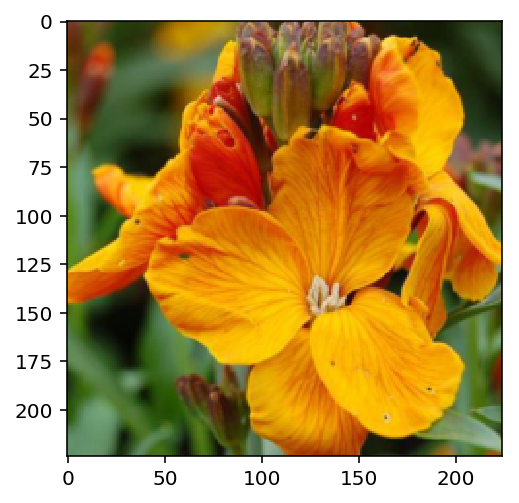

In [15]:
rand_dir = random.choice(os.listdir("flowers/test"))
print(cat_to_name[rand_dir])
image =  "flowers/test/" + rand_dir + "/" +random.choice(os.listdir("flowers/test/"+rand_dir))
imshow(process_image(image))

## Class Prediction

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    with torch.no_grad():
        img_tensor = process_image(image_path)
        img_tensor = img_tensor.to(device)
        img_tensor.unsqueeze_(0) # resize the tensor (add dimension for batch)

        model = model.to(device)
        model.eval()   # Set model to evaluate mode
  
    # apply data to model
        output = model(img_tensor).topk(topk)
        probs = torch.exp(output[0].to("cpu")).numpy().tolist()[0]
        classes = (output[1].to("cpu")).numpy().tolist()[0]
    
    return probs, classes

## Sanity Checking

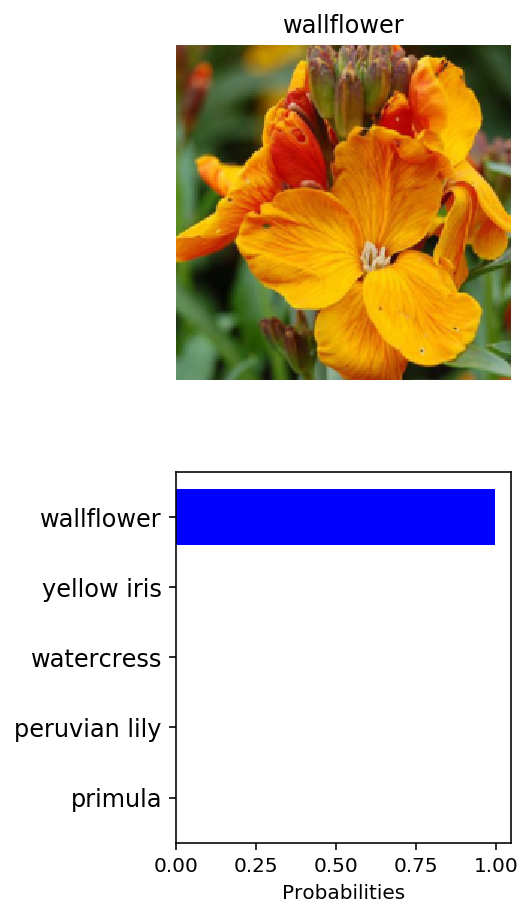

In [17]:
# Display an image along with the top 5 classes

probs, classes = predict(image, model, topk=5)

idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
names =[]

for i in range(len(classes)):
    names.append(cat_to_name[idx_to_class[classes[i]]])

with torch.no_grad():
    img_tensor = process_image(image)
    img_tensor = img_tensor.to("cpu")
    #img_tensor.unsqueeze_(0)

img = img_tensor.numpy().transpose((1, 2, 0))
    
# Undo preprocessing
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
    
# Image needs to be clipped between 0 and 1 or it looks like noise when displayed
img = np.clip(img, 0, 1)    
    
y_pos = np.arange(len(classes))

fig, (ax1, ax2) = plt.subplots(figsize=(3,7.5), nrows=2)
ax1.imshow(img)
ax1.set_title(names[0])
ax1.axis('off')
ax2.barh(y_pos, probs, align='center', color='blue')
#ax2.set_aspect(1.0)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(names, size='large');
#ax2.set_title('Class Probability')
#ax2.set_xlim(0, 1.1)
ax2.axis('auto')
ax2.invert_yaxis()
_ = ax2.set_xlabel('Probabilities')